# 新洋教育Kaggle零基础教学计划 - 计算机视觉项目
# Human Protein Atlas Image Classification

在此Kaggle竞赛中，参赛者需要建立机器学习模型实现显微镜下的混合蛋白质图像的分类（即一张图片拥有多个标签，为多标签分类问题）。[The Human Protein Atlas](https://www.proteinatlas.org/) 会使用这些模型来创建智能显微系统，进而从高分辨率图像中准确识别蛋白质类型。

蛋白质是人体细胞功能的执行者，维持着生命的正常运转。在之前的研究中，蛋白质图像分类的模式较为单一，图片上通常只有一种或少部分类别细胞。但是为了能够深入理解人类细胞机制的复杂性，此竞赛要求参赛者在存在多个不同类别细胞的图片中准确识别蛋白质类型。

细胞蛋白质的可视化常用于生物学研究，并且可以推动医药研究的突破。目前，由于高清显微镜技术的快速发展，图像数据产生的速度已经超过了数据处理的速度。因此，主办方希望通过此次竞赛研究生物图像自动分析的技术，以此推动人类对细胞和疾病的理解。

竞赛优胜者将受邀与 The Human Protein Atlas 团队一起在 Nature 旗下子刊 [*Nature Methods*](https://www.nature.com/nmeth) 上发文，此期刊最新影响因子高达28.467！

>**提示：**Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

我们将这个notebook分为不同的步骤，你可以使用下面的链接来浏览此notebook。

* [Step 1](#step1): 导入数据
* [Step 2](#step2): 数据研究
* [Step 3](#step3): 构建PyTorch数据集
* [Step 4](#step4): 搭建四通道CNN模型
* [Step 5](#step5): Focal Loss
* [Step 6](#step6): 模型训练
* [Step 7](#step7): 后处理与提交

在该项目中包含了如下的问题：

* [问题 1](#question1): 查阅资料并回答：如何解决训练数据中标签分布不均衡的问题？
* [问题 2](#question2): 此处可否简单采用`sklearn.model_selection`中的`StratifiedKFold`方法进行数据集切分？
* [问题 3](#question3): 简要概述Focal Loss与BCE Loss的差别。

In [1]:
import pandas as pd
import numpy as np
import random
import os
import cv2
import gc
import warnings
from sklearn.metrics import f1_score
from sklearn.exceptions import UndefinedMetricWarning
import scipy.optimize as opt
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
%matplotlib inline

<a id='step1'></a>
# 1. 导入数据

在此竞赛中，主办方给出了124288个训练样本和46808个测试样本。每个样本均由四张512$\times$512像素的单通道图片组成，分别代表红色（Red）、绿色（Green）、蓝色（Blue）和黄色（Yellow）四个通道。图片文件名由样本代号+通道代号组成，例如，样本代号为`00070df0-bbc3-11e8-b2bc-ac1f6b6435d0`的样本一共对应四张图片，分别为：
* 00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png
* 00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png
* 00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png
* 00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png

训练集中所有样本的代号记录在`train.csv`中，测试集中所有样本的代号记录在`sample_submission.csv`中。数据集中共含有28种人类蛋白质，其中训练集的标签在`train.csv`中给出。下面我们分别导入：

In [2]:
# 文件路径
TRAIN = '../input/human-protein-atlas-image-classification/train/'
TEST = '../input/human-protein-atlas-image-classification/test/'
LABELS = '../input/human-protein-atlas-image-classification/train.csv'
SUBMIT = '../input/human-protein-atlas-image-classification/sample_submission.csv'

In [3]:
# 标签中的数字与蛋白质种类的对应关系
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

N_CLASSES = len(name_label_dict)
print('The number of classes of Human Proteins in this competition is {}'.format(N_CLASSES))

The number of classes of Human Proteins in this competition is 28


In [4]:
# 训练集
df = pd.read_csv(LABELS)
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


可以看出一张图片上可能存在多个种类的蛋白质，即这个竞赛的任务实际上是一个多标签分类（Multi-Label Classification）问题。

In [5]:
# 测试集
sub_df = pd.read_csv(SUBMIT)
sub_df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


<a id='step2'></a>
# 2. 数据研究

在划分训练集与验证集时，要保证两个数据集中的标签分布尽可能一致，这样才能通过验证集有效评估模型的泛化能力。因此，在划分数据集之前，需要首先研究数据标签的分布情况。

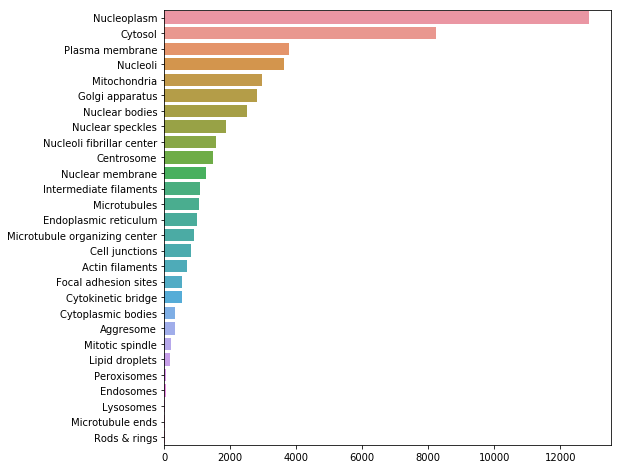

In [6]:
cls_counts = Counter(cls for classes in df['Target'].str.split() for cls in classes)
counts_x = [i[1] for i in cls_counts.most_common(N_CLASSES)]
counts_y = [name_label_dict[int(i[0])] for i in cls_counts.most_common(N_CLASSES)]
plt.figure(figsize=(8,8))
sns.barplot(y=counts_y, x=counts_x)

不难看出，`Nucleoplasm`和`Cytosl`两种蛋白质占据了标签的绝大部分，而`Lysosomes`、`Microtubule ends`和`Rods & rings`这三类蛋白质数量却相当少。经统计可得：数量最多的`Nucleoplasm`占比高达 25%，而数量最少的`Rods & rings`占比只有 0.02%。因此，此竞赛所处理的数据是一个典型的非均衡数据集。

<a id='question1'></a>
### __问题 1:__

查阅资料并回答：如何解决训练数据中标签分布不均衡的问题？

__回答:__ 

## 2.1 StratifiedKFold

为保证训练集与验证集中的标签分布的一致性，我们使用`StratifiedKFold`方法进行数据集的划分。`StratifiedKFold`为分层采样交叉切分，确保训练集、测试集中各类别样本的比例与原始数据集中相同。

In [7]:
# Fold划分
n_folds = 10
fold_cls_counts = defaultdict(int)
folds = [-1] * len(df)
for item in tqdm(df.sample(frac=1, random_state=42).itertuples(),total=len(df)):
    cls = min(item.Target.split(), key=lambda cls: cls_counts[cls])
    fold_counts = [(f, fold_cls_counts[f, cls]) for f in range(n_folds)]
    min_count = min([count for _, count in fold_counts])
    random.seed(item.Index)
    fold = random.choice([f for f, count in fold_counts if count == min_count])
    folds[item.Index] = fold
    for cls in item.Target.split():
        fold_cls_counts[fold, cls] += 1
df['fold'] = folds

In [8]:
df.head(10)

,Id,Target,fold
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,2
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,2
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,4
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,3
5,001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0,6
6,0020af02-bbba-11e8-b2ba-ac1f6b6435d0,25 2,9
7,002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0,6
8,00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,2 0,2
9,002daad6-bbc9-11e8-b2bc-ac1f6b6435d0,7,7


可以看到，每个样本都被划入相应的Fold中。接下来，我们只需要指定用作验证集的Fold，便可以完成训练集与验证集的划分。

<a id='question2'></a>
### __问题 2:__

此处可否简单采用`sklearn.model_selection`中的`StratifiedKFold`方法进行数据集切分？

__回答:__ 


In [9]:
valid_idx = 0
train_df = df[df['fold']!=valid_idx][['Id', 'Target']].reset_index(drop=True)
valid_df = df[df['fold']==valid_idx][['Id', 'Target']].reset_index(drop=True)
print('There are {} samples in the training set.'.format(len(train_df)))
print('There are {} samples in the validation set.'.format(len(valid_df)))

There are 28008 samples in the training set.
There are 3064 samples in the validation set.


## 2.2 图片数据预览

In [10]:
# 定义RGBY图片读取函数
def open_rgby(path, id, size=None): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    if size is None:
        img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255 
               for color in colors]
    else:
        img = []
        for color in colors:
            src_img = cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags)
            tar_img = cv2.resize(src_img, (size, size), interpolation=cv2.INTER_CUBIC).astype(np.float32)/255
            img.append(tar_img)

    return np.stack(img, axis=0)

In [11]:
def make_image_row(image, subax, title):
    subax[0].imshow(np.stack(image, axis=-1)[:,:,:3])
    subax[0].set_title('Id: '+title)
    subax[1].imshow(image[0], cmap="Reds")
    subax[1].set_title("Red Channel")
    subax[2].imshow(image[1], cmap="Greens")
    subax[2].set_title("Green Channel")
    subax[3].imshow(image[2], cmap="Blues")
    subax[3].set_title("Blue Channel")
    subax[4].imshow(image[3], cmap="Oranges")
    subax[4].set_title("Yellow Channel")
    return subax

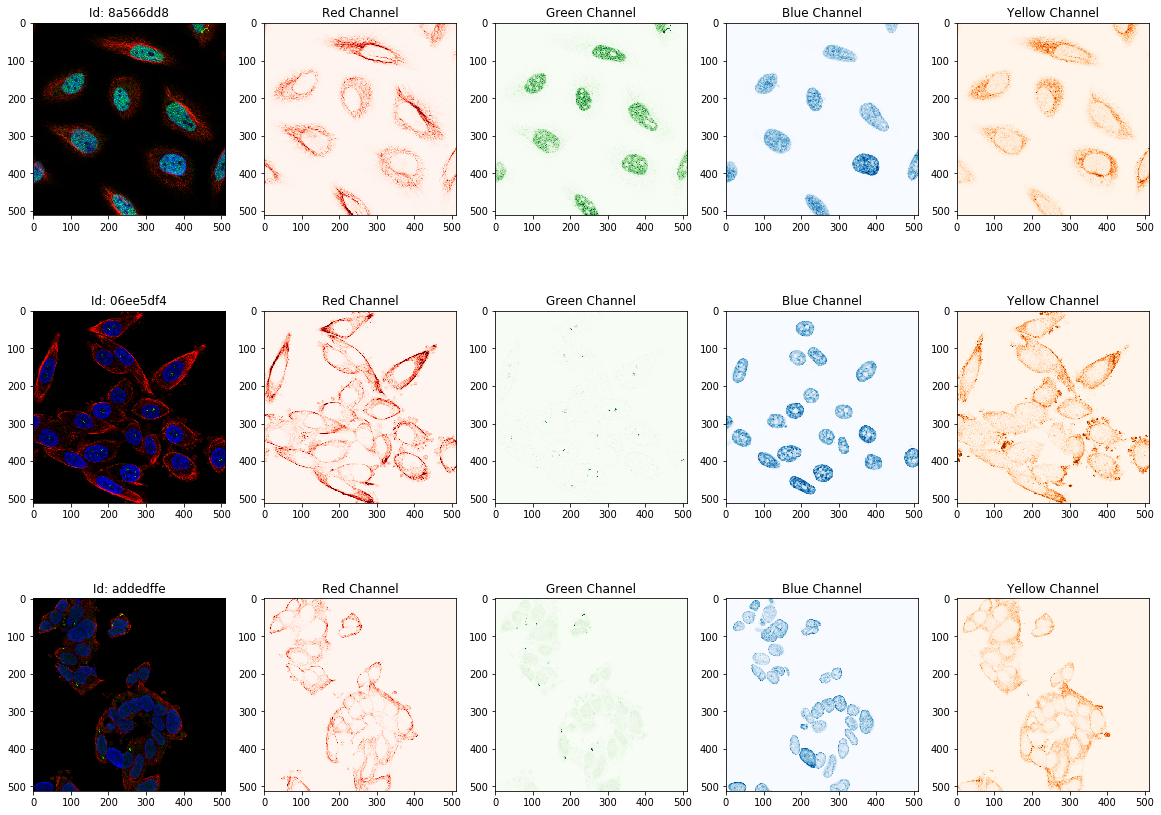

In [12]:
N_SAMPLES = 3
samples = np.array(train_df.sample(N_SAMPLES)['Id'])

fig, ax = plt.subplots(N_SAMPLES,5,figsize=(20,5*N_SAMPLES))
if ax.shape == (N_SAMPLES,):
    ax = ax.reshape(1,-1)
for n in range(N_SAMPLES):
    make_image_row(open_rgby(TRAIN, samples[n]), ax[n], samples[n].split('-')[0])

<a id='step3'></a>
# 3. 构建PyTorch数据集

在定义图片样本的读取函数之后，便可以开始构建用于PyTorch模型训练的数据集接口。由于这里的图片数据并不是标准的RGB格式，因此我们需要自定义`Dataset`，详细的构建方法可以参见此[博文](https://blog.csdn.net/u012436149/article/details/69061711)。标准的构建格式如下：

```python
class CustomDataset(Dataset): # from torch.utils.data import Dataset
    def __init__(self):
        # TODO
        # 1. Initialize file path or list of file names.
        pass
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        pass
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return 0
```
其中在`__init__`中完成类的继承和变量的定义，在`__getitem__`中完成对于某个index的样本的处理，并且返回该样本及其标签，在`__len__`中返回样本总量。在此，我们利用之前定义好的`train_df`、`valid_df`和`sub_df`完成数据集的构建。

In [13]:
class AtlasDataset(Dataset):
    def __init__(self, df, path, size=None, label=True):        
        self.df = df.copy()
        self.path = path
        self.size = size
        self.label = label
        if self.label:
            self.df['Target'] = [[int(i) for i in s.split()] for s in self.df['Target']] # 对标签进行预处理
        
    def __getitem__(self, index):        
        img = open_rgby(self.path, self.df['Id'].iloc[index], self.size)
        if self.label:
            target = np.eye(N_CLASSES,dtype=np.float)[self.df['Target'].iloc[index]].sum(axis=0) # 对标签进行独热编码
        else:
            target = np.zeros(N_CLASSES,dtype=np.int)
        return img, target
    
    def __len__(self):
        return len(self.df)

在定义好`Dataset`之后，便可以使用`torch.utils.data.DataLoader`完成对数据集的封装。

In [14]:
size= 512
bs = 64 # batch_size

In [15]:
train_loader = DataLoader(AtlasDataset(train_df, TRAIN, size), batch_size=bs, shuffle=True, num_workers=2)
valid_loader = DataLoader(AtlasDataset(valid_df, TRAIN, size), batch_size=bs, shuffle=True, num_workers=2)
test_loader  = DataLoader(AtlasDataset(sub_df, TEST, size, False), batch_size=bs, shuffle=False, num_workers=2)

<a id='step4'></a>
# 4. 搭建四通道CNN模型

传统的预训练CNN模型都是基于标准的RGB三通道格式的图片数据训练得到的。然而，此竞赛的数据为四通道图片，因此不能简单调用预训练模型进行训练。为了解决这一问题，我们可以将输入层卷积层的卷积核扩增一个维度，从而达到处理四通道图片数据的目的。

其中，RGB三个通道对应的卷积核参数仍采用imagenet预训练的权值，Y通道则采用随机权值。其他层仍采用imagenet权值进行初始化。

## CNN模型搭建

类似于数据集的搭建，PyTorch也是采用类的方法进行神经网络的搭建，其标准格式如下：
```python
class CustomNet(nn.Module):
    def __init__(self):
        pass
    
    def forward(self, x):
        return output

```
其中在`__init__`中完成类的继承和各个网络层的定义，在`forward`中完成对输入`x`前向传播的过程。PyTorch中的网络层相关接口可以查阅PyTorch官方文档：[https://pytorch.org/docs/stable/nn.html](https://pytorch.org/docs/stable/nn.html)（多看文档，熟能生巧）。

In [16]:
class AvgPool(nn.Module):
    def forward(self, x):
        return torch.squeeze(F.avg_pool2d(x, x.shape[2:]))

class ResNet34(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        encoder = resnet34(pretrained=False)
        if pretrained:            
            encoder.load_state_dict(torch.load('../input/pytorch-pretrained-models/resnet34-333f7ec4.pth'))
        # 在本地运行时此处直接改为 encoder = resnet34(pretrained=pretrained) 即可
        
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False) # 四通道卷积核
        
        if (pretrained):
            w = encoder.conv1.weight
            self.conv1.weight = nn.Parameter(torch.cat((w,0.5*(w[:,:1,:,:]+w[:,2:,:,:])),dim=1)) # 增加Y通道权值
        
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = nn.Sequential(self.conv1,self.relu,self.bn1,self.maxpool)
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        self.avgpool = AvgPool()
        self.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(encoder.fc.in_features, num_classes)) # 引入全连接层，完成分类
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.fc(x)        
        return x

In [17]:
model = ResNet34(num_classes=N_CLASSES)

<a id='step5'></a>
# 5. Focal Loss

注意到此竞赛的数据集是一个非均衡数据集，那么如果使用一般的`BCE Loss`，由于数据类别分布原因，模型会在预测时自动对数据量大的类别产生偏移。为了解决数据分布不均导致的问题，Facebook人工智能科学家Kaiming He提出一种新的损失函数：Focal Loss，这个损失函数是在标准交叉熵损失基础上修改得到的。这个函数可以通过减少易分类样本的权重：

${\rm FL}(p_t)=-(1-p_t)^\gamma\log(p_t)$

使得模型在训练时更专注于难分类的样本。对于Focal Loss的原理可以参考原论文（[链接](https://arxiv.org/abs/1708.02002)）。这里我们直接给出Focal Loss的PyTorch形式，其中 $\gamma$ 取 2。

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, logit, target):
        target = target.float()
        max_val = (-logit).clamp(min=0)
        loss = logit - logit * target + max_val + \
               ((-max_val).exp() + (-logit - max_val).exp()).log()

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size())==2:
            loss = loss.sum(dim=1)
        return loss.mean()

<a id='question3'></a>
### __问题 3:__

简要概述Focal Loss与BCE Loss的差别。

__回答:__ 

<a id='step6'></a>
# 6. 模型训练

## 6.1 准备工作

In [19]:
os.makedirs('models') # 用于储存模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
criterion = FocalLoss()
model = model.to(device)

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

PyTorch模型训练的标准格式为：
```python
model.train() # 开启训练模式，此时模型的参数可以修改
for batch_x, batch_y in DataLoader: # 从数据集中抽取batch
    optimizer.zero_grad() # 清空梯度
    output = model(batch_x) # 前向传播
    loss = criterion(output, batch_y) # 计算损失函数
    loss.backward() # 反向传播计算梯度
    optimizer.step() # 更新参数
```
灵活应用`optimizer`的梯度操作，可以达到梯度累积`gradient accumulation`的效果。在数据较大，GPU显存不够时，可以变相增大batch_size。

In [21]:
def train_model(epoch, history=None):
    model.train() 
    t = tqdm(train_loader)
    
    for batch_idx, (img_batch, label_batch) in enumerate(t):
        img_batch = img_batch.to(device)
        label_batch = label_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, label_batch)
        t.set_description(f'train_loss (l={loss:.4f})')
        
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()    
        optimizer.step()
    
    torch.save(model.state_dict(), 'models/epoch{}.pth'.format(epoch))

In [22]:
def binarize_prediction(probabilities, threshold: float, argsorted=None,
                        min_labels=1, max_labels=10):
    """ Return matrix of 0/1 predictions, same shape as probabilities.
    """
    assert probabilities.shape[1] == N_CLASSES
    if argsorted is None:
        argsorted = probabilities.argsort(axis=1)
    max_mask = _make_mask(argsorted, max_labels)
    min_mask = _make_mask(argsorted, min_labels)
    prob_mask = probabilities > threshold
    return (max_mask & prob_mask) | min_mask

def _make_mask(argsorted, top_n: int):
    mask = np.zeros_like(argsorted, dtype=np.uint8)
    col_indices = argsorted[:, -top_n:].reshape(-1)
    row_indices = [i // top_n for i in range(len(col_indices))]
    mask[row_indices, col_indices] = 1
    return mask

我们需要设定阈值，使得模型可以根据输出值与阈值的相对大小判断图像中是否存在某类蛋白。显然该阈值无法人为确定，这里我们可以观察不同阈值在验证集上的表现（Macro F1），从而确定最佳的阈值。

In [23]:
def evaluate(epoch, history=None): # 验证函数
    model.eval() # 开启验证模式，此时模型的参数不可修改
    valid_loss = 0.
    all_predictions, all_targets = [], []
    
    with torch.no_grad():
        for batch_idx, (img_batch, label_batch) in enumerate(valid_loader):
            all_targets.append(label_batch.numpy().copy())
            img_batch = img_batch.to(device)
            label_batch = label_batch.to(device)

            output = model(img_batch)
            loss = criterion(output, label_batch)
            valid_loss += loss.data
            predictions = torch.sigmoid(output)
            all_predictions.append(predictions.cpu().numpy())
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)
    
    valid_loss /= (batch_idx+1)
    
    if history is not None:
        history.loc[epoch, 'valid_loss'] = valid_loss.cpu().numpy()
    
    print('Epoch: {}\tLR: {:.6f}\tValid Loss: {:.4f}'.format(
        epoch, optimizer.state_dict()['param_groups'][0]['lr'], valid_loss))
    
    def get_score(y_pred):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=UndefinedMetricWarning)
            return f1_score(all_targets, y_pred, average='macro')
    
    metrics = {}
    argsorted = all_predictions.argsort(axis=1)
    # 测试不同阈值
    for threshold in [0.05,0.10,0.15,0.2,0.25,0.3,0.35,0.4,0.45]: 
        metrics[threshold] = get_score(
            binarize_prediction(all_predictions, threshold, argsorted))
    best_thr = max(metrics, key=metrics.get)
    print(' | '.join(f'thr_{k:.2f} {v:.3f}' for k, v in sorted(
        metrics.items(), key=lambda kv: -kv[1])[:5]))
    
    return valid_loss, best_thr, metrics[best_thr]

## 6.2 开始训练

In [24]:
history_train = pd.DataFrame()
history_valid = pd.DataFrame()

n_epochs = 100
init_epoch = 0
max_lr_changes = 1
valid_losses = []
threshold = {}
macro_f1 = {}
lr_reset_epoch = init_epoch
patience = 2
lr_changes = 0
best_valid_loss = 1000.

for epoch in range(init_epoch, n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history_train)
    valid_loss, best_thr, best_f1 = evaluate(epoch, history_valid)
    valid_losses.append(valid_loss)
    threshold[epoch] = best_thr
    macro_f1[epoch] = best_f1

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    elif (patience and epoch - lr_reset_epoch > patience and
          min(valid_losses[-patience:]) > best_valid_loss):
        # "patience" epochs without improvement
        lr_changes +=1
        if lr_changes > max_lr_changes: # 早期停止
            break
        lr /= 5 # 学习率衰减
        print(f'lr updated to {lr}')
        lr_reset_epoch = epoch
        optimizer.param_groups[0]['lr'] = lr


Epoch: 0	LR: 0.001000	Valid Loss: 1.0923
thr_0.30 0.232 | thr_0.35 0.219 | thr_0.25 0.217 | thr_0.40 0.189 | thr_0.20 0.189



Epoch: 1	LR: 0.001000	Valid Loss: 0.9841
thr_0.35 0.286 | thr_0.30 0.283 | thr_0.40 0.279 | thr_0.45 0.262 | thr_0.25 0.249



Epoch: 2	LR: 0.001000	Valid Loss: 0.8483
thr_0.40 0.362 | thr_0.35 0.358 | thr_0.45 0.350 | thr_0.30 0.329 | thr_0.25 0.276



Epoch: 3	LR: 0.001000	Valid Loss: 0.8201
thr_0.35 0.406 | thr_0.30 0.385 | thr_0.40 0.380 | thr_0.45 0.366 | thr_0.25 0.345



Epoch: 4	LR: 0.001000	Valid Loss: 0.8150
thr_0.40 0.395 | thr_0.45 0.388 | thr_0.35 0.386 | thr_0.25 0.371 | thr_0.30 0.368



Epoch: 5	LR: 0.001000	Valid Loss: 0.9341
thr_0.30 0.420 | thr_0.35 0.413 | thr_0.25 0.387 | thr_0.40 0.384 | thr_0.45 0.371



Epoch: 6	LR: 0.001000	Valid Loss: 0.8775
thr_0.45 0.446 | thr_0.40 0.446 | thr_0.35 0.433 | thr_0.30 0.415 | thr_0.25 0.362
lr updated to 0.0002



Epoch: 7	LR: 0.000200	Valid Loss: 0.7926
thr_0.40 0.508 | thr_0.35 0.507 | thr_0.45 0.485 | thr_0.30 0.483 | thr_0.25 0.453



Epoch: 8	LR: 0.000200	Valid Loss: 0.9195
thr_0.40 0.510 | thr_0.45 0.507 | thr_0.35 0.506 | thr_0.30 0.486 | thr_0.25 0.457



Epoch: 9	LR: 0.000200	Valid Loss: 1.1009
thr_0.40 0.494 | thr_0.45 0.487 | thr_0.35 0.485 | thr_0.30 0.479 | thr_0.25 0.470


## 6.3 训练过程可视化

Text(0, 0.5, 'Macro F1 Score')

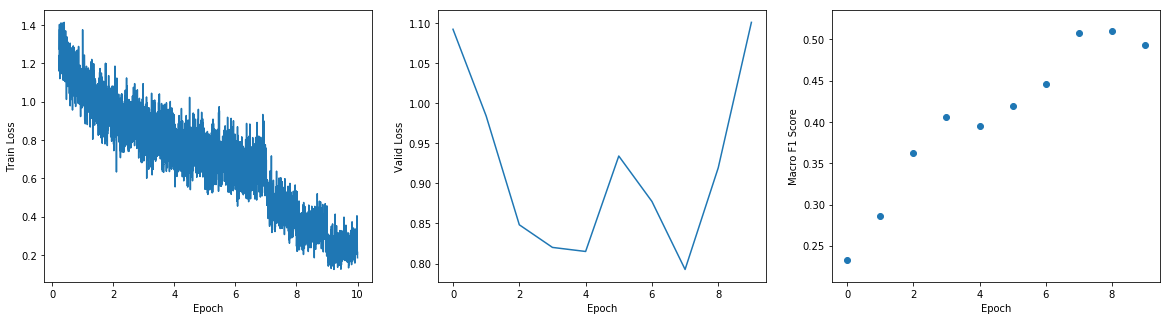

In [25]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].plot(history_train['train_loss'].iloc[100:])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Train Loss')

ax[1].plot(history_valid['valid_loss'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Valid Loss')

ax[2].scatter(macro_f1.keys(), macro_f1.values())
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Macro F1 Score')

<a id='step7'></a>
# 7. 后处理与提交

In [26]:
# 加载最佳模型
best_epoch = max(macro_f1, key=macro_f1.get)
print('The best epoch is epoch {}'.format(best_epoch))

model.load_state_dict(torch.load('models/epoch{}.pth'.format(best_epoch)))
model.eval();

The best epoch is epoch 8


In [27]:
# Inference
outputlist = []
for img_batch, _ in tqdm(test_loader):
    with torch.no_grad():
        output = torch.sigmoid(model(img_batch.to(device)))
    output = output.data.cpu().numpy()
    for i in output: 
        outputlist.append(i)

In [28]:
thr = threshold[best_epoch]
print('The best threshold is {:.3f}'.format(thr))

prediction = [' '.join([str(i) for i in np.argwhere((j > thr).astype(int)==1).reshape(-1)]) for j in outputlist]
sub_df['Predicted'] = prediction
sub_df.to_csv('submission.csv', index=False)

The best threshold is 0.400
